In [59]:
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pickle
import matplotlib.pyplot as plt

from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config 
from mrcnn.model import MaskRCNN 
from matplotlib.patches import Rectangle

In [60]:
# path of data folder
data_path = Path('rsna-pneumonia-detection-challenge')

## Labels data

In [61]:
labels_path = data_path / 'stage_2_train_labels.csv'

In [62]:
labels = pd.read_csv(labels_path)

In [63]:
labels.shape

(30227, 6)

In [64]:
labels.head(2)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0


##### id_to_intId: dict, mapping of each patient's id to a unique integer id

In [65]:
# id_to_intId = {id: i for i, id in enumerate(labels['patientId'].unique())}

# filename = 'id_to_intId'
# with open(filename, 'wb') as outfile:
#     pickle.dump(id_to_intId, outfile)

In [66]:
filename = 'id_to_intId'
with open(filename, 'rb') as infile:
    id_to_intId = pickle.load(infile)

In [67]:
IMAGE_WIDTH, IMAGE_HEIGHT = 1024, 1024

##### Note: 'stage_2_train_images_jpeg' is not included with the dataset, we generated it while analysing the data, code is present in the analysis file.

In [68]:
class PneumoniaDataset(Dataset):
    def load_dataset(self, dataset_dir, train_size=0.8, for_train=True):
        # define one class
        self.add_class('dataset', 1, 'pneumonia')
        # define data location (dcm)
        files_dir = dataset_dir / 'stage_2_train_images'
        files = np.asarray(sorted(os.listdir(str(files_dir))))
        n_files = len(files)
        
        # spliting data into train and test
        if for_train:
            train_filter = np.remainder(np.arange(n_files), int(train_size*10)) != 0
            files = files[train_filter]
        elif not for_train:
            test_filter = np.remainder(np.arange(n_files), int(train_size*10)) == 0
            files = files[test_filter]
            
        # extract bounding-box-position
        for filename in files:
            id = filename.split('.')[0]
            label = labels[labels['patientId'] == id].iloc[:, 1:]
            bboxes = []
            for _, bbox in label.iterrows():
                bboxes.append(bbox)
            image_id = id_to_intId[id]
            
            # extract image path (jpeg)
            imagename = id + '.jpeg'
            images_dir = dataset_dir / 'stage_2_train_images_jpeg'
            image_path = str(images_dir / imagename)
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=image_path, bboxes=bboxes)
            
        
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # get box-position
        bboxes = info['bboxes']
        # create one array for all masks, each on a different channel
        masks = np.zeros([IMAGE_HEIGHT, IMAGE_WIDTH, len(bboxes)], dtype='uint8')
        # create masks
        class_ids = []
        for i, bbox in enumerate(bboxes): 
            if  bbox['Target'] == 0:
                class_ids.append(self.class_names.index('pneumonia'))
                break
            # float to int
            bbox = bbox.astype(int)
            row_s, row_e = bbox['x'], bbox['x'] + bbox['width']
            col_s, col_e = bbox['y'], bbox['y'] + bbox['height']
            masks[col_s: col_e, row_s:row_e, i] = 1
            class_ids.append(self.class_names.index('pneumonia'))
        return (masks, np.asarray(class_ids, dtype='int32'))
    
    
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [69]:
# train set
train_set = PneumoniaDataset()
train_set.load_dataset(data_path, train_size=0.8, for_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test set
test_set = PneumoniaDataset()
test_set.load_dataset(data_path, train_size=0.8, for_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 23348
Test: 3336


In [71]:
train_set.image_ids

In [28]:
test_set.image_ids

array([0, 1, 2, 3, 4, 5, 6])

### Training dataset

In [72]:
# load an image
image_id = 42
image = train_set.load_image(image_id)
# load image mask
mask, class_id = train_set.load_mask(image_id)

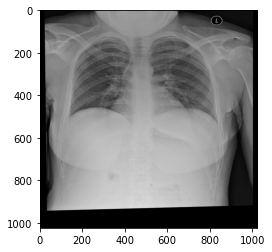

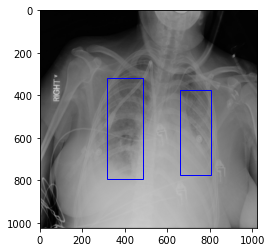

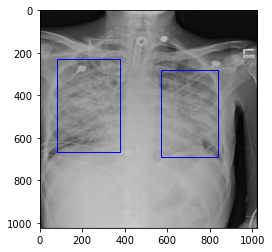

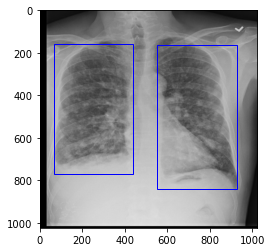

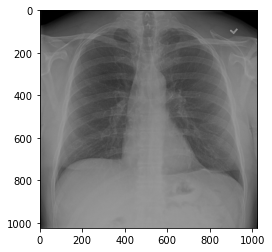

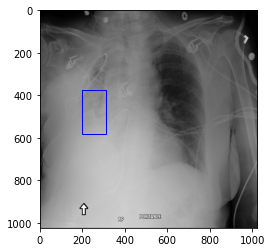

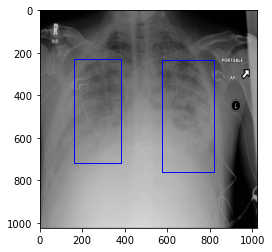

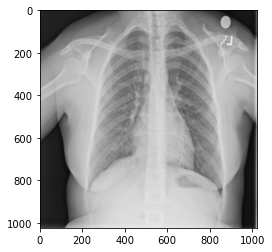

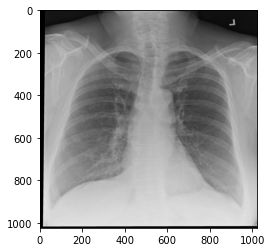

In [73]:
# plot first few images
for i in range(9):
    # define subplot
    fig, ax = plt.subplots(1)
#     plt.figure(figsize=(12, 12))
#     plt.subplot(330 + 1 + i)
    # plot raw pixel data
    image = train_set.load_image(i)
#     plt.imshow(image)
    # plot all masks
    mask, _ = train_set.load_mask(i)
    bboxes = extract_bboxes(mask)
    for bbox in bboxes:
        if np.sum(bbox) == 0:
            break
        y, x, y_, x_ = bbox 
        h, w = y_ - y, x_ - x
        patch = Rectangle((x, y), w, h, color='blue', fill=False)
        ax.add_patch(patch)
    ax.imshow(image)

# show the figure
plt.show()

In [74]:
# # enumerate all images in the dataset
# for image_id in train_set.image_ids:
#     # load image info
#     info = train_set.image_info[image_id]
#     # display on the console
#     print(info)

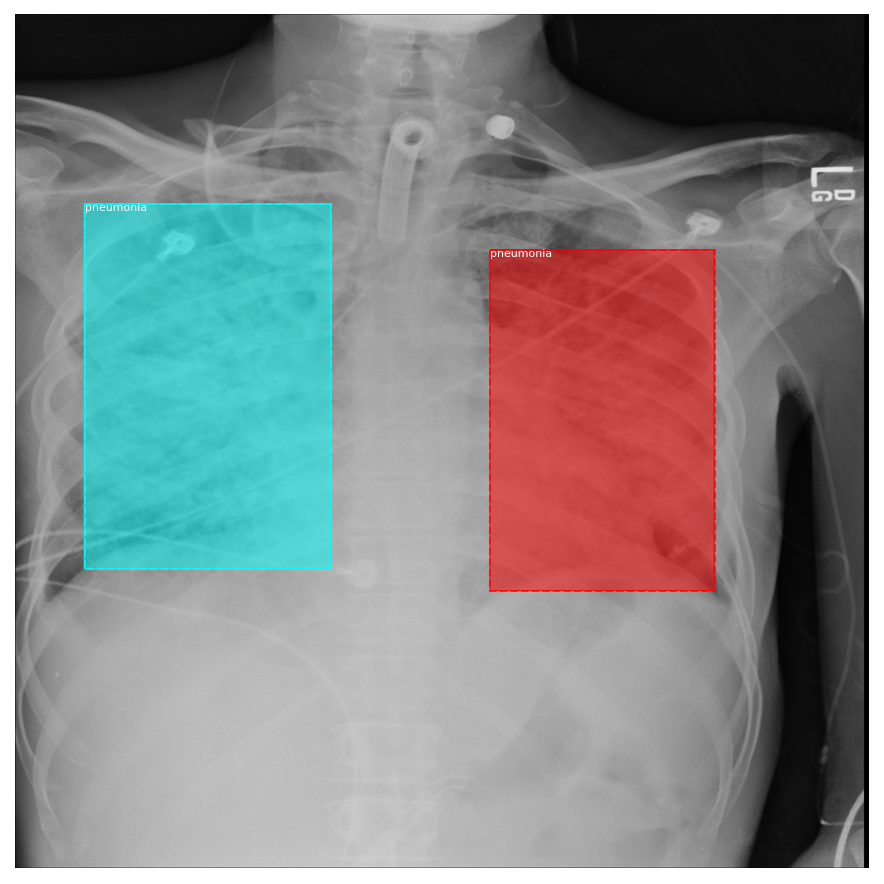

In [75]:
image_id = 2
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [76]:
# define a configuration of the model
class PneumoniaConfig(Config):
    # Give the configuration a recognizable name
    NAME = 'pneumonia_cfg'
    # Number of class (background + pneumonia)
    NUM_CLASSES = 1 + 1        
    # Number of training steps per epochs
    STEPS_PER_EPOCH = len(train_set.image_ids)
    
# prepare config
config = PneumoniaConfig()
print(config.LEARNING_RATE)

0.001


In [77]:
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)

In [78]:
COCO_MODEL_PATH = 'mask_rcnn_coco.h5'

In [79]:
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                                           "mrcnn_bbox", "mrcnn_mask"])

In [80]:
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=1, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./pneumonia_cfg20200919T1533\mask_rcnn_pneumonia_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4       

C:\Users\utkar\anaconda3\envs\pneumonia\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\utkar\anaconda3\envs\pneumonia\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\utkar\anaconda3\envs\pneumonia\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
    1/23348 [..............................] - ETA: 369:00:59 - loss: 10.7421 - rpn_class_loss: 0.1539 - rpn_bbox_loss: 8.6706 - mrcnn_class_loss: 1.9176 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

KeyboardInterrupt: 